# Baseline решение от команды mipt dudes ( Черновик )

## Библиотеки и таблица с данными

In [39]:
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('data.csv')
df = df.drop(columns=['embedding_text', 'embedding_query'])
print(df.shape)
df.head()

(47021, 3)


,query,text,label
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",1
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,1
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни...",1
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...,1


## Метрика 

Интуиция - предполагается что будет дальнейшая обработка результата, так что нам важно хорошо попадать в первые топ N ответов. При этом хочется чтобы все правильные ответы шли выше чем неправильные.  

Пусть n - этого всего ответов на запрос, из них k - правильных.  

Метрика это процент правильных ответов, которые находятся среди первых max(3, k) позиций после ранжирования


In [6]:
def custom_metric(df_sorted):
    # n - общее количество ответов, k - количество правильных ответов
    n = len(df_sorted)
    k = df_sorted['label'].sum()
    
    # Количество позиций для оценки
    top_k = max(3, int(k))
    
    # Отбираем первые top_k ответов после ранжирования
    top_k_answers = df_sorted.iloc[:top_k]
    
    # Считаем количество правильных ответов среди первых top_k
    correct_in_top_k = top_k_answers['label'].sum()
    
    # Рассчитываем процент правильных ответов среди первых top_k
    score = correct_in_top_k / k
    
    return score


## Ранжирование

Ранжирование основано на косинусное мере близости эмбеддингов предложений.  

Мы просто берём эмбеддинги из предобученной модели и считаем косинусное расстояние от эмбеддинга вопроса к эмбеддингу ответа.  

Далее делаем софтмакс по всем ответам к конкретному запросу и добавляем полученные вероятности в таблицу.  

Возвращаем отсортированную==отранжированную таблицу.

In [9]:
def rank_answers(df, model_name='cointegrated/rubert-tiny'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Применяем токенизацию с обрезанием длины
    def encode_text(text):
        return tokenizer.encode(text, max_length=512, truncation=True, return_tensors='pt')
    queries = df['query'].apply(encode_text)
    answers = df['text'].apply(encode_text)
    
    # Рассчитываем косинусное сходствo
    similarities = []
    for query, answer in zip(queries, answers):
        with torch.no_grad():
            query_embedding = model(query).last_hidden_state.mean(dim=1)  # Получаем эмбеддинг для запроса
            answer_embedding = model(answer).last_hidden_state.mean(dim=1)  # Эмбеддинг для ответа
            similarity = torch.cosine_similarity(query_embedding, answer_embedding).item()
            similarities.append(similarity)
    
    # Применяем softmax к косинусным сходствам
    similarities_tensor = torch.tensor(similarities)
    similarities_softmax = F.softmax(similarities_tensor, dim=0).numpy()
    
    df_copy = df.copy()
    df_copy['similarity'] = similarities_softmax
    
    # Сортируем по сходству
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    return df_sorted

## Эксперимент

In [17]:
res = []
#i=0
for quey, text in df.groupby('query'):
    i+=1
    x = rank_answers(text)
    score = custom_metric(x)
    n = len(x)
    k = x['label'].sum()
    res.append([quey,score, n, k])
    print(quey, 'score =',score,'N =',n, 'K =', k)
    #if i ==6:
    #    break

456 — инопланетная раса- это раса из какого фильма? score = 0.0 N = 11 K = 1
AKB48 выступала в России? score = 1.0 N = 1 K = 1
BBC частная или государственная компания? score = 1.0 N = 1 K = 1
Daewoo Lanos собирали на Украине? score = 1.0 N = 1 K = 1
Higurashi no Naku Koro ni стала любительской игрой в Японии? score = 1.0 N = 14 K = 1
Joy Division распалась? score = 0.25 N = 10 K = 4
M16 выпускается в США на март 2019? score = 1.0 N = 1 K = 1
M3 поставлялся на экспорт? score = 0.75 N = 10 K = 8
Queen посещала Россию? score = 1.0 N = 1 K = 1
Sex Pistols была скандальной группой? score = 0.75 N = 10 K = 8
«Агенты "Щ.И.Т."» - это драматический сериал? score = 0.5 N = 11 K = 2
«Двадцать восемь панфиловцев» стал лучшим фильмом России 2016 года? score = 0.5 N = 10 K = 2
«Джойнт» была отмечена премией государства Израиль? score = 1.0 N = 10 K = 2
«Ислáмское госудáрство»- террористическая организация? score = 0.25 N = 10 K = 4
«Лос-Анджелес Лейкерс» был чемпионом НБА? score = 0.777777777777777

In [18]:
len(res)

5935

In [33]:
summ_score = 0
summ_N = 0
summ_k = 0
for elem in res:
    summ_score += elem[1]
    summ_N += elem[2]
    summ_k += elem[3]
print(summ_score/len(res),summ_N/len(res),summ_k/len(res) )

0.5862124068947995 7.922662173546756 2.2847514743049704


**В среднем 8 ответом, из них 2.3 правильных, мы находим их в топ 3 не хуже чем с вероятностью 58%, что сильно лучше случайного гадания.**

In [38]:
from collections import defaultdict

res_dict_N = defaultdict(float)
res_dict_N_count = defaultdict(int)
res_dict_k = defaultdict(float)
res_dict_k_count = defaultdict(int)

for elem in res:
    res_dict_N[elem[2]] += elem[1]
    res_dict_N_count[elem[2]] += 1
    res_dict_k[elem[3]] += elem[1]
    res_dict_k_count[elem[3]] += 1
list_for_N = []
for key, value in res_dict_N.items():
    list_for_N.append([key, value/res_dict_N_count[key]])

print(sorted(list_for_N))
print('----------')
list_for_k = []
for key, value in res_dict_k.items():
    list_for_k.append([key, value/res_dict_k_count[key]])
    
print(sorted(list_for_N))

[[1, 1.0], [2, 1.0], [3, 1.0], [4, 0.8571428571428571], [5, 0.9722222222222222], [8, 1.0], [9, 0.4143939393939394], [10, 0.45399301561741184], [11, 0.39907781695861166], [12, 0.43904761904761913], [13, 0.35815412186379925], [14, 0.4555555555555556], [15, 0.5476190476190476], [16, 0.3333333333333333], [17, 0.2833333333333333], [18, 0.3333333333333333], [19, 0.25]]
----------
[[1, 1.0], [2, 1.0], [3, 1.0], [4, 0.8571428571428571], [5, 0.9722222222222222], [8, 1.0], [9, 0.4143939393939394], [10, 0.45399301561741184], [11, 0.39907781695861166], [12, 0.43904761904761913], [13, 0.35815412186379925], [14, 0.4555555555555556], [15, 0.5476190476190476], [16, 0.3333333333333333], [17, 0.2833333333333333], [18, 0.3333333333333333], [19, 0.25]]


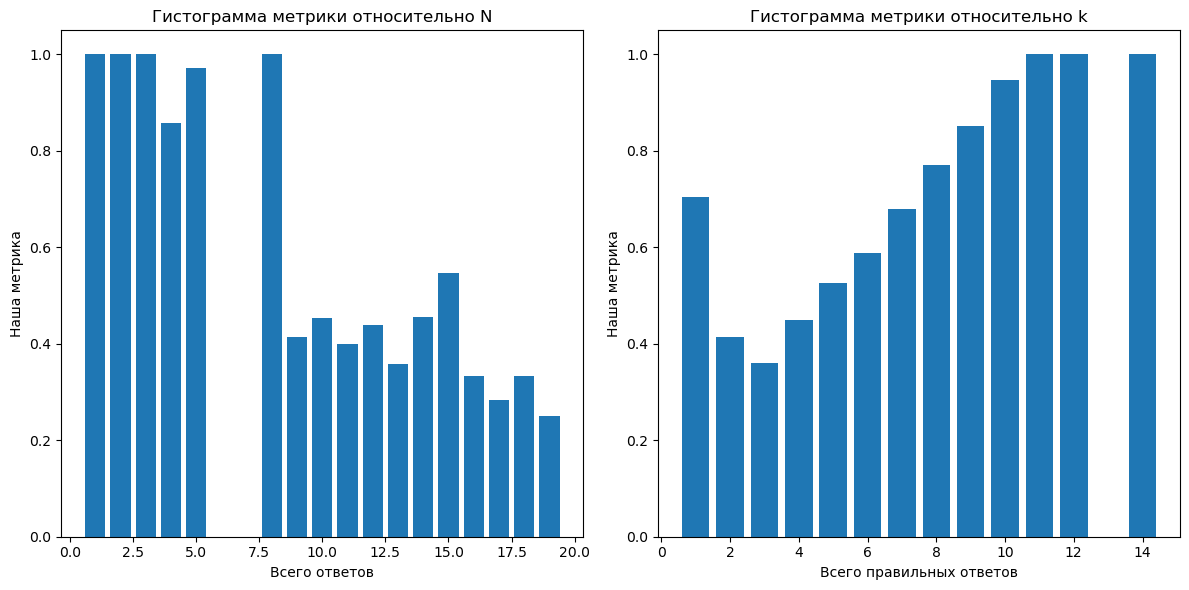

In [43]:
# Разделяем списки на отдельные списки для координат x и y
N_x = [x[0] for x in list_for_N]
N_y = [x[1] for x in list_for_N]

k_x = [x[0] for x in list_for_k]
k_y = [x[1] for x in list_for_k]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(N_x, N_y)
plt.xlabel('Всего ответов')
plt.ylabel('Наша метрика')
plt.title('Гистограмма метрики относительно N')

plt.subplot(1, 2, 2)
plt.bar(k_x, k_y)
plt.xlabel('Всего правильных ответов')
plt.ylabel('Наша метрика')
plt.title('Гистограмма метрики относительно k')

plt.tight_layout()
plt.show()

## Анализ результатов:
  - Разработали решение и метрику оценки результата
  - Провели эксперимент
    - Результаты нормальные, но проблемы когда мало правильных ответов или много всего вариантов. Но всё же сильно лучше случайного гадания
    - Вопросы к эмбеддингам, так как тексты специфичны и содержат много ньюансов. Как пример - наличие букв с указанными ударениями. Такие буквы неправильно воспринимаются моделью эмбеддингов, из-за чего искажается результирующий вектор.
  - Как итог план улучшений:
    - Исследование новых эмбеддингов
    - Предобработка текста
    - Улучшение модели, применение других вариантов решений

### Пример с буквой с ударением

In [21]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')
model = AutoModel.from_pretrained('cointegrated/rubert-tiny')
    
# Применяем токенизацию с обрезанием длины
def encode_text(text):
    return tokenizer.encode(text, max_length=512, truncation=True, return_tensors='pt')
text = encode_text('Костю́шко')

with torch.no_grad():
    text_embedding1 = model(text).last_hidden_state.mean(dim=1)  # Получаем эмбеддинг для запроса
text_embedding1

tensor([[ 5.7062e-01,  3.0109e-01, -5.4013e-01, -1.0372e+00, -3.4536e-01,
          7.6075e-01,  2.4740e-01, -2.7223e-01, -3.7028e-01, -9.8163e-01,
          6.0616e-01, -1.0680e-01, -3.9639e-01,  8.0913e-01, -3.5805e-01,
         -1.4527e-01,  4.7264e-01, -1.4870e-01,  8.3897e-01,  1.6099e+00,
         -2.3144e-01, -2.1939e-01,  5.2106e-01, -6.8175e-01,  1.1952e+00,
         -1.6812e-02,  4.8239e-01,  1.5233e-01,  3.0133e-01,  7.7653e-01,
         -3.2775e-01,  3.3021e-01,  2.6976e-01, -2.8723e-01,  7.0539e-02,
          9.3151e-01,  1.4906e-01, -5.5081e-01, -4.3074e-01,  8.9520e-02,
          3.2299e-01,  2.0453e-01,  1.0696e+00, -5.7897e-01,  2.1416e-01,
         -5.0939e-01, -1.0015e-01, -5.3544e-01,  1.4970e-01, -5.0475e-02,
          6.5669e-01, -7.0352e-01, -6.4887e-01, -3.8866e-01, -1.1254e+00,
          2.1700e-01,  1.0483e+00,  1.2265e-01, -3.5934e-01,  8.0235e-02,
          3.0652e-01,  6.1540e-01, -6.3716e-02,  6.5657e-01,  1.6145e-01,
          4.6496e-01, -7.0663e-02, -3.

In [22]:
text = encode_text('Костюшко')

with torch.no_grad():
    text_embedding2 = model(text).last_hidden_state.mean(dim=1)  # Получаем эмбеддинг для запроса
text_embedding2

tensor([[ 5.1812e-01,  5.1631e-01, -4.7143e-01, -1.0847e+00, -2.1510e-01,
          8.1388e-01,  2.8395e-01, -8.5789e-02, -4.0581e-01, -7.8925e-01,
          7.4257e-01, -3.3416e-01, -2.2374e-01,  9.8474e-01, -4.4486e-01,
         -2.3760e-01,  4.5337e-01, -1.3030e-03,  9.0442e-01,  1.5773e+00,
         -2.2499e-01, -1.4615e-01,  6.8150e-01, -6.5799e-01,  1.0085e+00,
          1.5149e-01,  3.1006e-01,  3.5921e-01,  1.4890e-01,  9.7998e-01,
         -6.1513e-01,  1.9100e-02,  2.3167e-01, -5.6899e-02,  2.2708e-01,
          1.1635e+00,  2.2482e-01, -4.7765e-01, -2.9390e-01,  2.2855e-02,
          5.8462e-01,  1.2949e-01,  1.3110e+00, -4.6095e-01,  4.1853e-01,
         -3.6628e-01,  1.6587e-01, -5.2312e-01,  1.8616e-01,  1.9678e-02,
          6.6617e-01, -5.8809e-01, -6.7988e-01, -3.9126e-01, -8.6370e-01,
          2.9800e-01,  1.2985e+00,  2.4709e-01, -3.1937e-01,  2.7713e-01,
          3.1121e-01,  7.4521e-01, -9.1931e-02,  3.2423e-01,  8.6943e-02,
          4.8576e-01, -2.8681e-01, -3.

In [28]:
torch.sum(torch.abs(text_embedding1-text_embedding2)), len(text_embedding1[0])

(tensor(38.0704), 312)

## Старое

без софтмакса

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

def rank_answers(df, model_name='cointegrated/rubert-tiny'):
    # Загрузка модели и токенизатора
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Применяем токенизацию с обрезанием длины
    def encode_text(text):
        return tokenizer.encode(text, max_length=512, truncation=True, return_tensors='pt')
    
    # Создаем представления для запросов и ответов
    queries = df['query'].apply(encode_text)
    answers = df['text'].apply(encode_text)
    
    # Рассчитываем сходства (например, косинусное)
    similarities = []
    for query, answer in zip(queries, answers):
        with torch.no_grad():
            query_embedding = model(query).last_hidden_state.mean(dim=1)  # Получаем эмбеддинг для запроса
            answer_embedding = model(answer).last_hidden_state.mean(dim=1)  # Эмбеддинг для ответа
            similarity = torch.cosine_similarity(query_embedding, answer_embedding).item()
            similarities.append(similarity)
    
    # Используем .loc для изменения DataFrame
    df.loc[:, 'similarity'] = similarities
    
    # Сортируем по сходству
    df_sorted = df.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    
    return df_sorted
